# 생성적 적대 신경망(Generative Adversarial Networks)[GAN]:
딥러닝의 원리를 이용하여 가상 이미지를 생성하는 알고리즘

- adversarial은 GAN 알고리즘을 잘 설명하는 단어; 생성자(Generator)와 판별자(Discriminator)이 적대적 경합을 하기 때문이다.



# DCGAN(Deep Convolutional GAN):
페이스북 AI 연구팀이 발표한 CNN을 GAN에 적용한 알고리즘

In [44]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, Activation, BatchNormalization, LeakyReLU, Conv2D, UpSampling2D
from keras.datasets import mnist

import matplotlib.pyplot as plt
import numpy as np

- 배치 정규화(Batch Normalization): 평균이 0, 분산이 1이 되도록 재배치하는 것


> 다음 층으로 입력될 값을 일정하게 재배치한다. 이를 통해 층의 개수가 늘어나도 안정적인 학습을 진행하게 한다.



- LeakyReLU : 기존 렐루 함수에서 x값이 음수이면 무조건 0이 되어 뉴런이 일찍 소실되는 단점을 보완 (LeakyReLU(0.2)은 0보다 작으면 0.2를 곱하라는 의미)

In [45]:
# 생성자 모델
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))   # 7*7인 이유는 (1),(2)에서 두배가 되기 때문 (128과 input_dim은 임의의 숫자)
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))                                       # 컨볼루션 레이어가 받아들일 수 있는 형태로 변경 (괄호 갯수 주의)
generator.add(UpSampling2D())                                             #(1) 7*7 -> 14*14
generator.add(Conv2D(64, kernel_size=5, padding='same'))                  #padding='same' 모자라는 부분을 0으로 채워준다
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))                                 # 기존 렐루는 GAN에서 불안정해 변형한 LeakyReLU 사용
generator.add(UpSampling2D())                                             #(2) 14*14 -> 28*28
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))# tanh를 쓰면 출력이 -1 ~ 1이 된다. MNIST 손글씨 픽셀 범위도 -1 ~ 1로 맞추면 판별조건이 갖춰진다.

UpSampling2D를 이용하여 이미지 크기를 점점 늘려가는 것이 DCGAN의 특징이다.
- UpSampling2D와 Conv2D가 합쳐진 **Conv2DTranspose()** 함수를 이용하면 된다.


In [46]:
# 판별자 모델
# 컨볼루션 신경망 구조를 그대로 사용
# 판별자는 학습하지 않으므로 가중치를 저장하는 학습기능을 꺼야함
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same')) #strides를 사용하면 드롭아웃이나 풀링 효과가 생긴다.
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')             
discriminator.trainable = False                                                 # 학습기능 off

In [47]:
# 생성자와 판별자 모델을 연결시키는 gan 모델
ginput = Input(shape=(100,))                                                    # 랜덤한 100개의 벡터를 입력
dis_output = discriminator(generator(ginput))                                   # 생성자가 만든 것을 판별자에 입력한 것
gan = Model(ginput, dis_output)                                                 # 생성자와 판별자 연결
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_14 (Sequential)  (None, 28, 28, 1)         865281    
                                                                 
 sequential_15 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [50]:
# 신경망 실행 함수
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기(앞서 사용한 MNIST 재사용, 테스트 과정은 필요 없고, 이미지만 사용하기에 X_train만 호출)
  (X_train,_), (_, _) = mnist.load_data()
  X_tain = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  # 127.5를 뺀 후 127.5로 나누어 -1~1 사의 값으로 변경
  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1)) #모두 1인 레이블을 가진 배열. batch_size 길이 만큼 생성
  fake = np.zeros((batch_size, 1))  #가상의 이미지들

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력하는 부분
    idx = np.random.randint(0, X_train.shape[0], batch_size)                    #np.random.randint(a,b,c) a부터 b까지 숫자중 하나를 c번 반복해서 가져오라
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)                      #train_on_batch(x,y) 입력값x와 레이블y를 받아서 한번 학습을 실시해 모델을 업데이트한다.

    # 가상 이미지를 판별자에 입력
    noise = np.random.normal(0, 1, (batch_size, 100))                           #정수가 아니므로 .normal / (batch_size, 100): batch_size 만큼 100열을 뽑아라
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    #판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

    # 중간 과정을 이미지로 저장하는 부분. (정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 것)
    if i % saving_interval == 0:
        #r, c = 5, 5
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        count = 0
        for j in range(5):
          for k in range(5):
            axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[j, k].axis('off')
            count += 1
        fig.savefig("./gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 83ms/step
epoch:0  d_loss:0.5693  g_loss:0.1313
1/1 [==============================] - 0s 86ms/step
epoch:1  d_loss:0.5471  g_loss:0.1856
1/1 [==============================] - 0s 84ms/step
epoch:2  d_loss:0.4938  g_loss:0.3618
1/1 [==============================] - 0s 81ms/step
epoch:3  d_loss:0.4464  g_loss:0.5995
1/1 [==============================] - 0s 83ms/step
epoch:4  d_loss:0.4654  g_loss:0.7983
1/1 [==============================] - 0s 83ms/step
epoch:5  d_loss:0.5220  g_loss:0.7947
1/1 [==============================] - 0s 84ms/step
epoch:6  d_loss:0.6580  g_loss:0.7240
1/1 [==============================] - 0s 87ms/step
epoch:7  d_loss:0.8090  g_loss:0.5609
1/1 [==============================] - 0s 83ms/step
epoch:8  d_loss:0.7595  g_loss:0.5173
1/1 [==============================] - 0s 95ms/step
epoch:9  d_loss:0.7743  g_loss:0.4674
1/1 [==============================] - 0s 82ms/step
epoch:10  d_loss:0.6384  g_loss:0.5181
1/1 [====

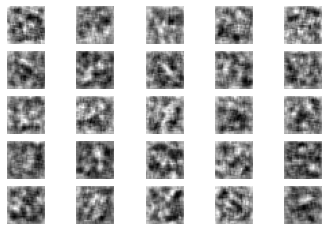

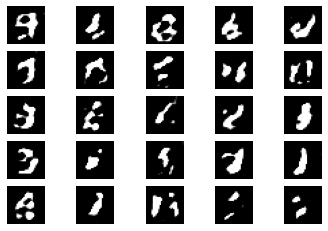

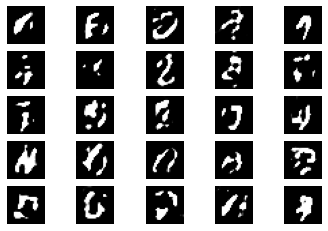

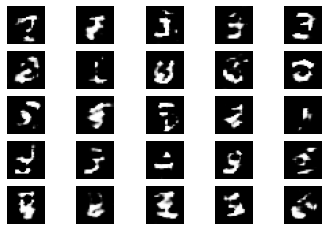

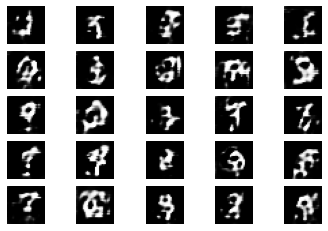

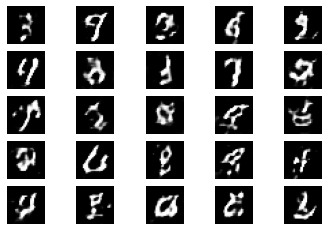

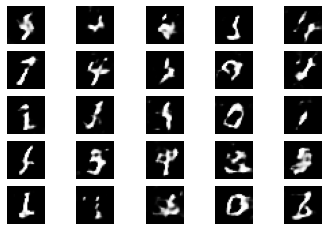

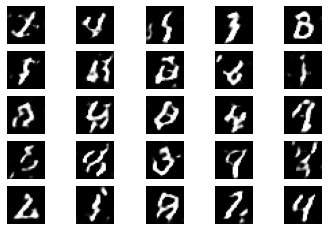

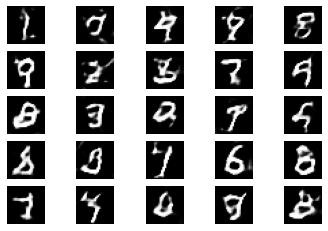

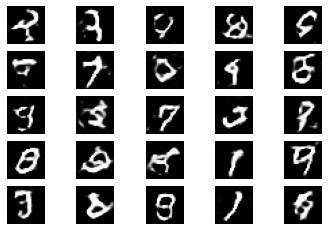

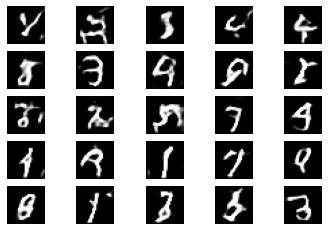

In [51]:
# 2000번 반복(+1주의), 배치 크기는 32, 200번마다 결과 저장
gan_train(2001, 32, 200)